<a href="https://colab.research.google.com/github/Yasser1910/REER/blob/main/reer_box.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

# Example path to your file:
file_path = '/content/drive/MyDrive/REER/reer_data.csv'

# Load your CSV
import pandas as pd
df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

Mounted at /content/drive


<ipython-input-7-59757b6d1129>:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')


In [10]:
# Full Python script to analyze Oman's REER using real data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# === Step 1: Load your dataset ===
# Replace this with your actual file path
# Make sure your columns are named: 'Date', 'REER', 'NEER', 'Oman_CPI', 'Foreign_CPI'
df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
# Log transformation
df['ln_reer'] = np.log(df['REER'])
df['ln_neer'] = np.log(df['NEER'])
df['ln_dom_cpi'] = np.log(df['Oman_CPI'])
df['ln_for_cpi'] = np.log(df['Foreign_CPI'])
df['inflation_diff'] = df['ln_for_cpi'] - df['ln_dom_cpi']

# ADF Test Function
def run_adf(series, name):
    result = adfuller(series.dropna())
    print(f"\nADF Test for {name}:")
    print(f"  ADF Statistic: {result[0]:.4f}")
    print(f"  p-value: {result[1]:.4f}")
    if result[1] < 0.05:
        print("  ✅ Stationary (reject H0 of unit root)")
    else:
        print("  ⚠️ Non-stationary (fail to reject H0)")

# Run ADF tests
for col in ['ln_reer', 'ln_neer', 'ln_dom_cpi', 'ln_for_cpi']:
    run_adf(df[col], col)

# First differences
data_diff = df[['ln_reer', 'ln_neer', 'ln_dom_cpi', 'ln_for_cpi']].diff().dropna()

# Fit VAR model
var_model = VAR(data_diff)
var_results = var_model.fit(maxlags=12, ic='aic')

print("\nVAR Summary (selected lags):")
print(var_results.summary())

# Johansen cointegration test
print("\nJohansen Cointegration Test:")
coint_result = coint_johansen(df[['ln_reer', 'ln_neer', 'ln_dom_cpi', 'ln_for_cpi']].dropna(), det_order=0, k_ar_diff=1)
for i, trace in enumerate(coint_result.lr1):
    print(f"  Trace Statistic for r ≤ {i}: {trace:.2f},  Critical Value (95%): {coint_result.cvt[i, 1]}")
    if trace > coint_result.cvt[i, 1]:
        print("    ✅ Cointegration relationship exists at this rank")
    else:
        print("    ❌ No cointegration at this rank")

# OLS regression
X = sm.add_constant(df[['ln_neer', 'inflation_diff']].dropna())
y = df['ln_reer'].loc[X.index]
ols_model = sm.OLS(y, X).fit()

print("\nOLS Regression: ln(REER) ~ ln(NEER) + Inflation Differential")
print(ols_model.summary())



ADF Test for ln_reer:
  ADF Statistic: 0.5471
  p-value: 0.9862
  ⚠️ Non-stationary (fail to reject H0)

ADF Test for ln_neer:
  ADF Statistic: 0.4557
  p-value: 0.9835
  ⚠️ Non-stationary (fail to reject H0)

ADF Test for ln_dom_cpi:
  ADF Statistic: -2.4598
  p-value: 0.1256
  ⚠️ Non-stationary (fail to reject H0)

ADF Test for ln_for_cpi:
  ADF Statistic: -0.8568
  p-value: 0.8019
  ⚠️ Non-stationary (fail to reject H0)

VAR Summary (selected lags):
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, May, 2025
Time:                     19:51:53
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -46.4445
Nobs:                     178.000    HQIC:                  -46.6570
Log likelihood:           3175.09    FPE:                4.72251e-21
AIC:                     -46.8020    Det(Omega_mle):     4.22716e-21
----------------------

<ipython-input-10-de791c5a18ef>:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


<ipython-input-13-267eb0e37577>:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df =  pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


AttributeError: 'VECMResults' object has no attribute 'fevd'

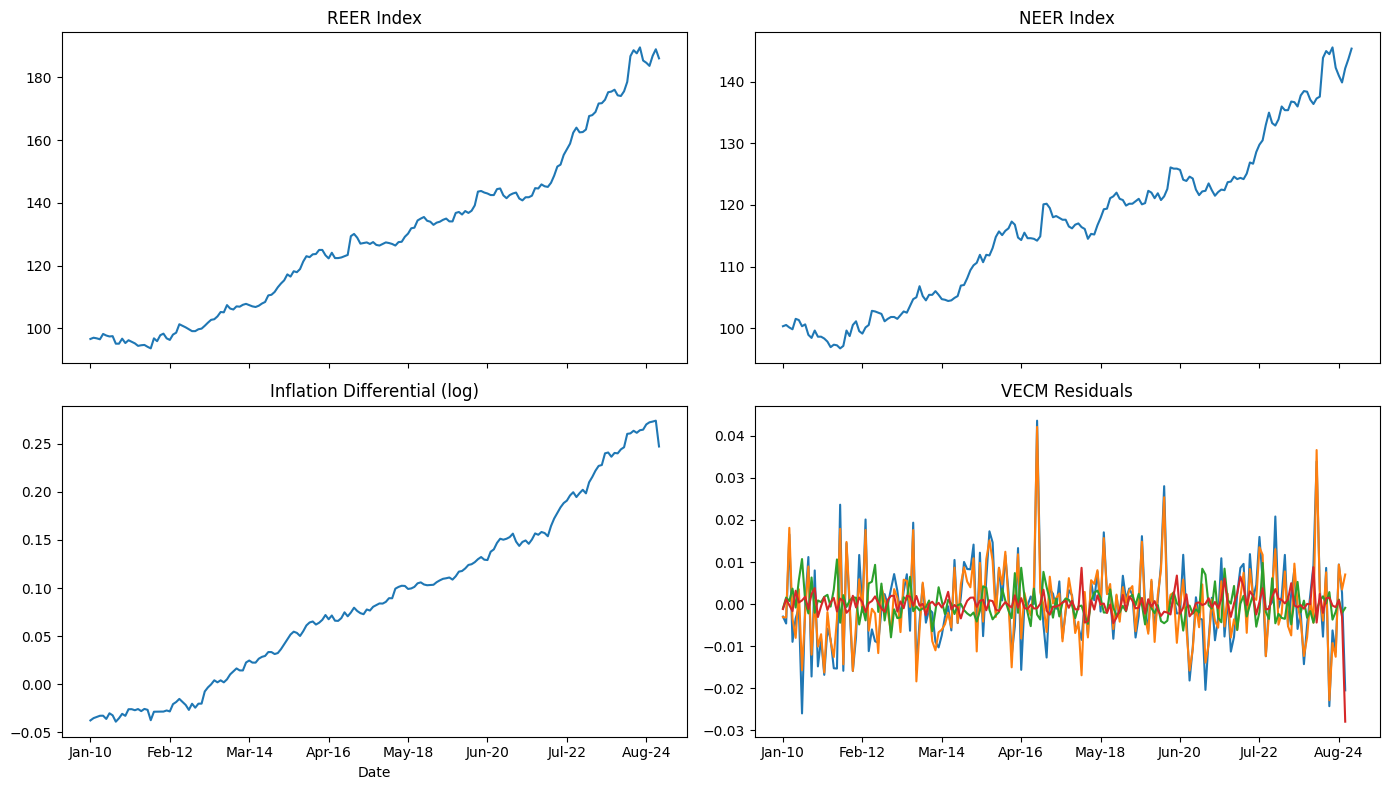

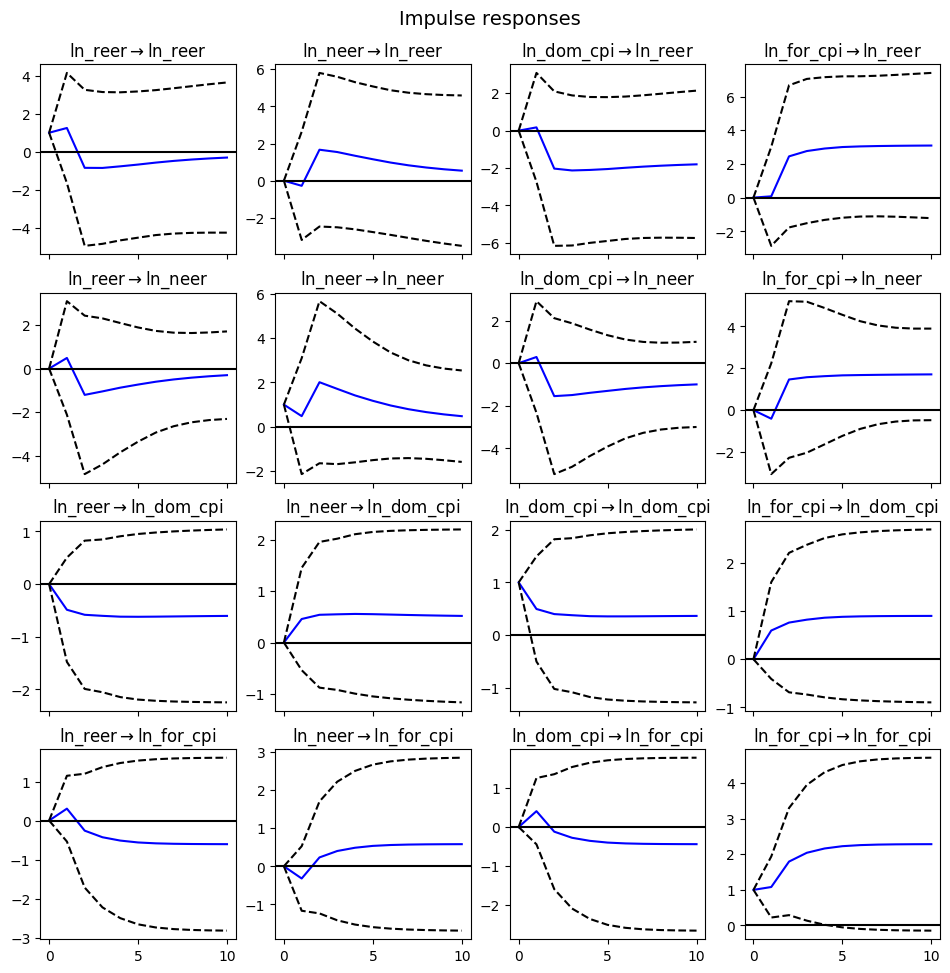

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.stattools import adfuller
from statsmodels.api import OLS, add_constant
from sklearn.preprocessing import StandardScaler

# Sample structure for DataFrame creation (will be replaced by actual loaded data)
# df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

#Connecting to data

df =  pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

# Calculate logs
df['ln_reer'] = np.log(df['REER'])
df['ln_neer'] = np.log(df['NEER'])
df['ln_dom_cpi'] = np.log(df['Oman_CPI'])
df['ln_for_cpi'] = np.log(df['Foreign_CPI'])
df['inflation_diff'] = df['ln_for_cpi'] - df['ln_dom_cpi']

# Select variables for VECM
vecm_df = df[['ln_reer', 'ln_neer', 'ln_dom_cpi', 'ln_for_cpi']].dropna()

# Johansen Cointegration Test
johan_res = coint_johansen(vecm_df, det_order=0, k_ar_diff=1)

# Create summary of trace statistics
johansen_summary = pd.DataFrame({
    'Trace Statistic': johan_res.lr1,
    'Critical Value (95%)': johan_res.cvt[:, 1]
}, index=[f'r <= {i}' for i in range(len(johan_res.lr1))])

# Fit VECM with rank from Johansen (assume rank=2 based on user result)
vecm_model = VECM(vecm_df, k_ar_diff=1, coint_rank=2, deterministic='co')
vecm_fit = vecm_model.fit()

# Collect the long-run coefficients and summary
vecm_summary = vecm_fit.summary()

# Extract residuals for diagnostics
residuals = vecm_fit.resid

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)
df['REER'].plot(ax=axes[0, 0], title='REER Index')
df['NEER'].plot(ax=axes[0, 1], title='NEER Index')
df['inflation_diff'].plot(ax=axes[1, 0], title='Inflation Differential (log)')
axes[1, 1].plot(residuals)
axes[1, 1].set_title('VECM Residuals')
plt.tight_layout()

# Show Impulse Response Functions
irf = vecm_fit.irf(10)
irf.plot(orth=False)

# Forecast Error Variance Decomposition
fevd = vecm_fit.fevd(10)
fevd.plot()

# Interpretation (basic comments)
vecm_interpretation = """
Interpretation Notes:
1. Johansen test confirmed cointegration → VECM is valid.
2. The VECM captures both long-term equilibrium and short-term dynamics.
3. IRFs show how a shock to one variable affects others over time.
4. FEVD tells how much of the forecast variance of REER is explained by NEER, inflation, etc.
5. Statistically significant error correction term implies adjustment to equilibrium.

Recommended focus:
- Look at significance of error correction terms (ECTs).
- IRF plots: strong NEER to REER transmission?
- FEVD: which variable dominates REER forecast variance?
"""

(johansen_summary, vecm_summary, vecm_interpretation)